In [9]:
import numpy as np
import cv2
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [10]:
def estimate_noise_component_frequency(noisy_image, min_distance=10):
    """
    Estimate the noise component using improved frequency domain filtering.

    Args:
        noisy_image: Input noisy image
        min_distance: Minimum distance between peaks
    """
    # Convert to float
    img_float = noisy_image.astype(float)

    # Apply 2D FFT
    fft = np.fft.fft2(img_float)
    fft_shift = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shift)
    log_magnitude = np.log1p(magnitude)

    # Get image center
    rows, cols = magnitude.shape
    center_row, center_col = rows // 2, cols // 2

    # Create distance matrix from center
    y, x = np.ogrid[-center_row:rows-center_row, -center_col:cols-center_col]
    distance_from_center = np.sqrt(x*x + y*y)

    # Create a mask to exclude very low and very high frequencies
    min_freq_radius = 5
    max_freq_radius = min(rows, cols) // 4
    frequency_band_mask = (distance_from_center > min_freq_radius) & (distance_from_center < max_freq_radius)

    # Find local maxima in magnitude spectrum
    local_max = np.zeros_like(magnitude, dtype=bool)
    window_size = 3
    for i in range(window_size, rows-window_size):
        for j in range(window_size, cols-window_size):
            window = magnitude[i-window_size:i+window_size+1, j-window_size:j+window_size+1]
            if magnitude[i,j] == np.max(window):
                local_max[i,j] = True

    # Apply threshold based on local statistics
    mean_magnitude = np.mean(magnitude[frequency_band_mask])
    std_magnitude = np.std(magnitude[frequency_band_mask])
    threshold = mean_magnitude + 3 * std_magnitude

    # Create mask for periodic noise
    peaks = (magnitude > threshold) & local_max & frequency_band_mask

    # Symmetrize the peaks (important for real-valued output)
    peaks = peaks | np.flip(peaks)

    # Create frequency domain filter with smooth transition
    freq_filter = np.zeros_like(fft_shift, dtype=complex)
    freq_filter[peaks] = 1

    # Smooth the filter
    freq_filter = cv2.GaussianBlur(freq_filter.real, (3,3), 0) + \
                 1j * cv2.GaussianBlur(freq_filter.imag, (3,3), 0)

    # Apply filter to get noise component in frequency domain
    noise_fft = fft_shift * freq_filter

    # Transform back to spatial domain
    noise = np.real(np.fft.ifft2(np.fft.ifftshift(noise_fft)))

    return noise, peaks, magnitude

def reduce_periodic_noise(image, window_size=7):
    """
    Main function to reduce periodic noise in an image using improved frequency domain filtering.
    """
    # Convert image to float for calculations
    g = image.astype(float)

    # Estimate noise component using frequency domain filtering
    eta, peaks, magnitude = estimate_noise_component_frequency(g)

    # Calculate weight function
    w = calculate_weight_function(g, eta, window_size)

    # Calculate the final estimate using the reconstruction formula
    f_hat = g - w * eta

    # Clip and convert back to uint8
    return np.clip(f_hat, 0, 255).astype(np.uint8), peaks, magnitude

def visualize_frequency_analysis(image):
    """Visualize the improved frequency domain analysis of the image."""
    # Get noise estimate and visualization data
    noise, peaks, magnitude = estimate_noise_component_frequency(image)

    plt.figure(figsize=(15, 5))

    # Original magnitude spectrum
    plt.subplot(131)
    plt.imshow(np.log1p(magnitude), cmap='viridis')
    plt.title('Magnitude Spectrum (log scale)')
    plt.colorbar()

    # Detected peaks
    plt.subplot(132)
    plt.imshow(peaks, cmap='gray')
    plt.title('Detected Frequency Peaks')

    # Filtered magnitude spectrum
    plt.subplot(133)
    filtered_magnitude = magnitude * peaks
    plt.imshow(np.log1p(filtered_magnitude), cmap='viridis')
    plt.title('Filtered Magnitude Spectrum')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# The rest of the code (add_periodic_noise, calculate_weight_function, plot_results) remains the same



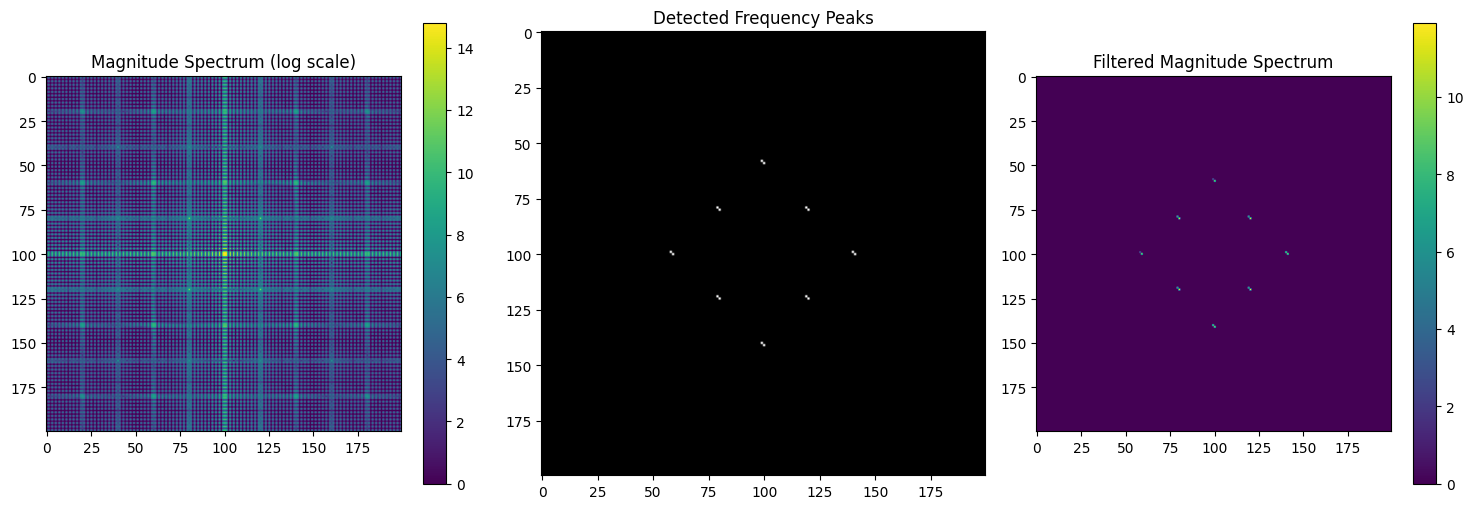

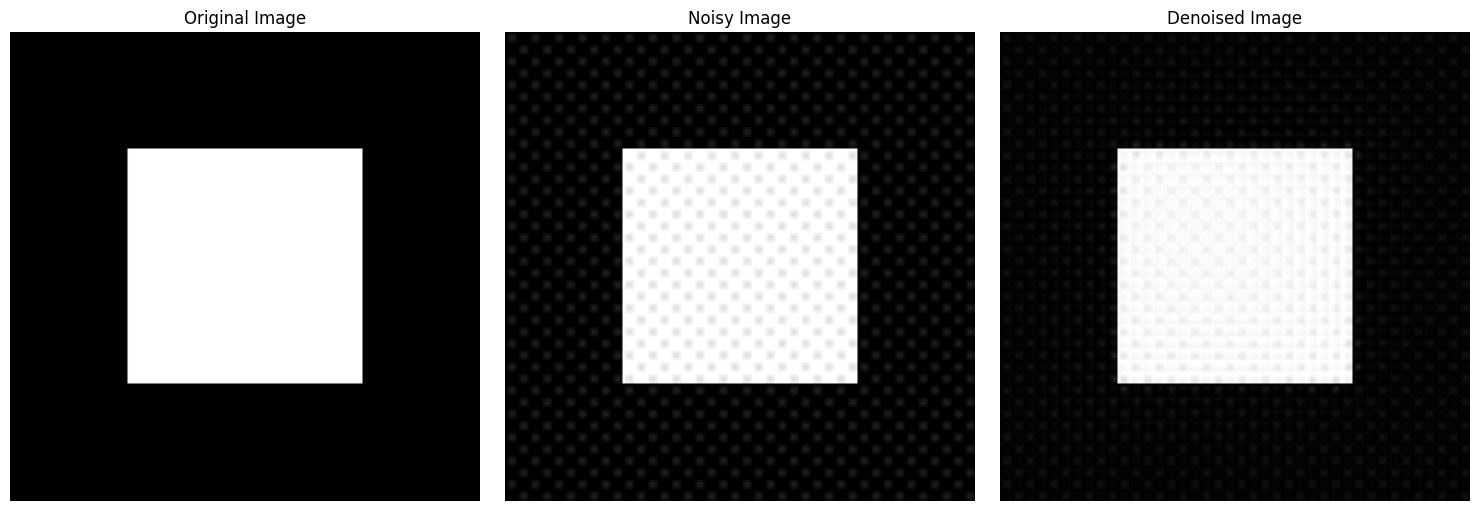

In [11]:
def main():
    # Create a test image
    image = np.zeros((200, 200), dtype=np.uint8)
    image[50:150, 50:150] = 255  # White square on black background

    # Add periodic noise
    noisy_image = add_periodic_noise(image)

    # Visualize frequency analysis
    visualize_frequency_analysis(noisy_image)

    # Reduce noise
    denoised_image, peaks, magnitude = reduce_periodic_noise(noisy_image)

    # Plot results
    plot_results(image, noisy_image, denoised_image)

if __name__ == "__main__":
    main()